### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import nltk
import unicodedata
from contractions import contractions_dict
import re
from nltk.corpus import wordnet
import collections
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from nltk.tokenize import word_tokenize

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations


In [4]:
df['job_type'].value_counts()

Permanent             15777
Contract/Interim       1414
Contract/Temp           305
Temporary/Seasonal      113
Any                      25
Part-Time                23
Name: job_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='job_type'>

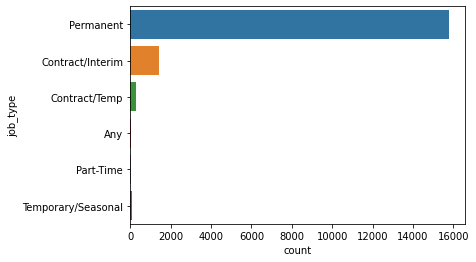

In [5]:
sns.countplot(data = df, y = 'job_type')

In [6]:
df['category'].value_counts()

Pharmaceutical, Healthcare and Medical Sales    4507
Clinical Research                               3172
Science                                         2932
Manufacturing & Operations                      2235
Regulatory Affairs                              1163
Pharmaceutical Marketing                        1071
Data Management and Statistics                   829
Quality-assurance                                703
Medical Information and Pharmacovigilance        561
Medical Affairs / Pharmaceutical Physician       458
Pharmacy                                          26
Name: category, dtype: int64

<AxesSubplot:xlabel='count', ylabel='category'>

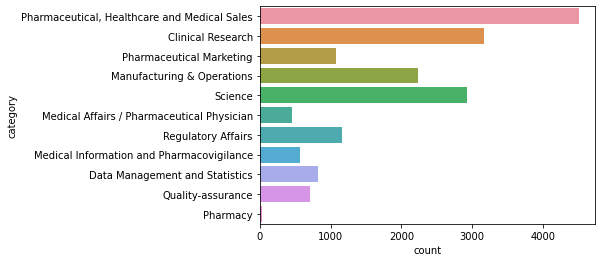

In [7]:
sns.countplot(data = df, y = 'category')

In [8]:
df['job_description'][0]

" Zest Scientific is searching for an accomplished Scientific Sales professional in the Netherlands. This territory will play a pivotal role as the company increases their presence across Europe, presenting a wealth of untapped potential. Our client is internationally recognized for providing 'best in class' solutions. This region provides excellent growth opportunities for a motivated and entrepreneurial Technical Sales Specialist. This is a highly autonomous role where your input will be encouraged and you will be provided with the platform in which to implement your own selling methods / business plan.\r\r\r\nThe Candidate:\r\r\r\n * You will demonstrate a successful track record selling into academic research, clinical diagnostics / hospital laboratories or biotech accounts.\r\r\r\n * Ability to learn new scientific concepts as you will be required to take a 'hands on' approach supporting customers at all stages of the sales process.\r\r\r\n * Independent and comfortable working wi

### Data Preprocessing

In [9]:
# removing stop words (is, a...)
def rem_stop(sent):
    stop_words = set(stopwords.words('english'))
 
    word_tokens = word_tokenize(sent)
 
    cleansent = [w for w in word_tokens if not w.lower() in stop_words]
     
    cleansent = []
 
    for w in word_tokens:
         if w not in stop_words:
            cleansent.append(w)
    cleansent = ' '.join(cleansent)
    return cleansent

In [10]:
# remove html tage if any
def remove_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    if bool(soup.find()):
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    else:
        stripped_text = text
    return stripped_text

In [11]:
# Don't -> Do not, I'd -> I would
def expand_contractions(text):
    
    expanded_words = []   
    for word in text.split():
  # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  
   
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [12]:
# converting é to e.
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [13]:
#stemming
def stem(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [14]:
#Lemmatization
def lemmatize_text(text):
    wnl = WordNetLemmatizer()
    list1 = nltk.word_tokenize(text)
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list1])
    return lemmatized_string

In [15]:
#remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]'
    text = re.sub(pattern, '', text)
    return text

In [16]:
def preprocess_text(sen, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, remove_digits=True,
                     special_char_removal = True,
                     stopword_removal=True):
    
    if html_stripping:
            sen = remove_tags(sen)
    if accented_char_removal:
            sen = remove_accented_chars(sen)
   
    if contraction_expansion:
            sen = expand_contractions(sen)

    if text_lemmatization:
            sen = lemmatize_text(sen)    
            
    if special_char_removal:  
            special_char_pattern = re.compile(r'([{.(-)!}])')
            sen = special_char_pattern.sub(" \\1 ", sen)
            sen = remove_special_characters(sen, remove_digits=remove_digits)      
            
    if text_lower_case:
            sen = sen.lower()    

    if stopword_removal:
            sen = rem_stop(sen)    
            
    return sen   


In [17]:
#Passing sentences to the preprocessing function
z = []
sentences = list(df['job_description'])
for sen in sentences:
    z.append(preprocess_text(sen))

In [18]:
z[0]

'zest scientific searching accomplished scientific sales professional netherlands territory play pivotal role company increase presence across europe presenting wealth untapped potential client internationally recognized providing best class solution region provides excellent growth opportunity motivated entrepreneurial technical sales specialist highly autonomous role input encouraged provided platform implement selling method business plan candidate demonstrate successful track record selling academic research clinical diagnostics hospital laboratory biotech account ability learn new scientific concept required take hands approach supporting customer stage sale process independent comfortable working limited support enterprising willingness exceed customer expectation excellent relationship builder first class communicator role responsible delivering annual sale plan developing existing key account strategically identifying new development opportunity within clinical diagnostics labo

In [19]:
df['processedJD'] = z
df.head()

,job_no,job_description,job_type,category,processedJD
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",zest scientific searching accomplished scienti...
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research,en el mundo de los cro tipicos esta compania e...
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,asha mistry umbilical life recruiting experien...
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",sales representative laser der medizintechnik ...
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,field service engineer life science cambridge ...


### Training

In [20]:
traindf = df[['processedJD', 'job_type', 'category']]

In [21]:
X = traindf['processedJD']
Y = traindf[['job_type', 'category']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25, random_state=42)

In [23]:
from xgboost import XGBClassifier
pipeline_xgb =Pipeline([
                ('vect', CountVectorizer(tokenizer=word_tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(XGBClassifier())) ])


In [24]:
# xgbparams = {
#         'clf__estimator__learning_rate':[0.05, 0.10, 0.15, 0.20],
#         'clf__estimator__max_depth' : [ 3, 4, 5, 6],
#         "clf__estimator__min_child_weight" : [ 1, 3, 5, 7 ],
#         "clf__estimator__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4],
#         "clf__estimator__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
#          }

In [25]:
# random_search=RandomizedSearchCV(pipeline_xgb,param_distributions=xgbparams,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# random_search.fit(X_train, y_train)

In [26]:
# random_search.best_estimator_

In [27]:
# xgb = random_search.best_estimator_

In [28]:
# xgb.fit(X_train, y_train)

In [29]:
# pred_xgb = xgb.predict(X_test)

In [30]:
pipeline_xgb.fit(X_train, y_train)

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function word_tokenize at 0x000002BB7BBD5268>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               enable_categorical=False,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type=None,
                                                               interac

In [31]:
pred_xgb = pipeline_xgb.predict(X_test)

### Model evaluation

In [32]:
def Extract(lst):
    l1 = []
    l1 = [item[0] for item in lst]
    return l1

def Extract2(lst):
    l1 = []
    l1 = [item[1] for item in lst]
    return l1

In [33]:
e1 = Extract(pred_xgb)
e2 = y_test['job_type']

In [34]:
t1 = f1_score(e2, e1, average = 'weighted') #'micro' uses the global number of TP, FN, FP and calculates the F1 directly

In [35]:
e3 = e1 = Extract2(pred_xgb)
e4 = y_test['category']

In [36]:
t2 = f1_score(e4, e3, average = 'weighted')

In [37]:
testdf = pd.read_csv('test.csv')

In [38]:
t = []
sentences = list(testdf['job_description'])
for sen in sentences:
    t.append(preprocess_text(sen))

In [39]:
testdf['processedJD'] = t

In [40]:
processedJD_pred = pipeline_xgb.predict(testdf['processedJD'])

In [41]:
preddf = pd.DataFrame(processedJD_pred, columns = ('job_type', 'category'))
preddf

,job_type,category
0,Permanent,Data Management and Statistics
1,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
2,Permanent,Science
3,Permanent,Pharmaceutical Marketing
4,Permanent,Clinical Research
...,...,...
11766,Permanent,Clinical Research
11767,Permanent,Clinical Research
11768,Permanent,Quality-assurance
11769,Permanent,Clinical Research


In [42]:
predictions = pd.concat([testdf, preddf], axis=1)

In [43]:
predictions = predictions.drop(['processedJD','job_description'], axis = 1)
predictions

,job_no,job_type,category
0,Id-1,Permanent,Data Management and Statistics
1,Id-2,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
2,Id-4,Permanent,Science
3,Id-6,Permanent,Pharmaceutical Marketing
4,Id-7,Permanent,Clinical Research
...,...,...,...
11766,Id-29421,Permanent,Clinical Research
11767,Id-29422,Permanent,Clinical Research
11768,Id-29425,Permanent,Quality-assurance
11769,Id-29426,Permanent,Clinical Research


In [44]:
predictions.to_csv('xgb.csv', index=False)

In [45]:

# pipeline_gb =Pipeline([
#                 ('vect', CountVectorizer(tokenizer=word_tokenize)),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', MultiOutputClassifier(GradientBoostingClassifier())) ])

In [46]:
# params = {
#         'clf__estimator__learning_rate':[0.05, 0.10, 0.15, 0.20],
#         'clf__estimator__max_depth' : [ 3, 4, 5, 6]
#          }

In [47]:

# random_search=RandomizedSearchCV(pipeline_gb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# random_search.fit(X_train, y_train)

In [48]:
# gb = random_search.best_estimator_

In [49]:
#gb.fit(X_train, y_train)

In [50]:
#pred_gb = gb.predict(X_test)

In [51]:
# #Creating a DT pipeline 
# pipeline =Pipeline([
#                 ('vect', CountVectorizer(tokenizer=word_tokenize)),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', MultiOutputClassifier(DecisionTreeClassifier())) ])

In [52]:
# pipeline.fit(X_train, y_train)

In [53]:
# y_pred = pipeline.predict(X_test)

In [54]:
# # RandomForest Pipeline
# rfpipeline =Pipeline([
#                 ('vect', CountVectorizer(tokenizer=word_tokenize)),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', MultiOutputClassifier(RandomForestClassifier()))])

In [55]:
# rfpipeline.fit(X_train, y_train)

In [56]:
# prd = rfpipeline.predict(X_test)

In [57]:
# params = {
#         'clf__estimator__min_samples_split': (10,30,50,100),
#         'clf__estimator__max_depth': (30,50,100)
#          }

In [58]:
# # Using RandomSearchCV to find the best parameters
# from sklearn.model_selection import RandomizedSearchCV
# random_search=RandomizedSearchCV(rfpipeline,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# random_search.fit(X_train, y_train)

In [59]:
# rf = random_search.best_estimator_

In [60]:
# rf.fit(X_train, y_train)

In [61]:
# pred_rf = rf.predict(X_test)

In [62]:
# testdf = pd.read_csv('test.csv')

In [63]:
# testdf.head

In [64]:
# t = []
# sentences = list(testdf['job_description'])
# for sen in sentences:
#     t.append(preprocess_text(sen))

In [65]:
# testdf['processedJD'] = t

In [66]:
# processedJD_pred = rf.predict(testdf['processedJD'])

In [67]:
# preddf = pd.DataFrame(processedJD_pred, columns = ('job_type', 'category'))
# preddf

In [68]:
# predictions = pd.concat([testdf, preddf], axis=1)
# predictions = predictions.drop(['processedJD','job_description'], axis = 1)

In [69]:
# predictions

In [70]:
# predictions.to_csv('Final_Prediction.csv', index=False)

In [71]:
# final_pred = rf.predict(testdf['job_description'])

In [72]:
# final_pred